In [1]:
import tqdm
import mlmi
import mlmi3
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.cluster
import sklearn.covariance
import networkx as nx
import densratio
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)

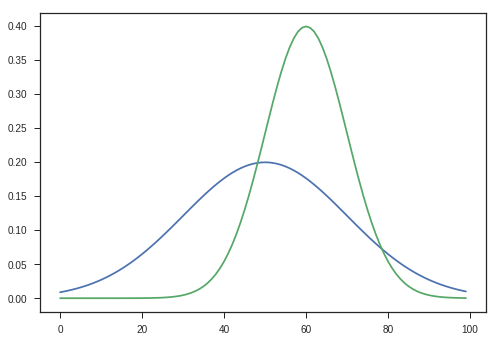

In [2]:
plt.plot([scipy.stats.norm(0, 2).pdf(x) for x in np.arange(-5, 5, 0.1)])
plt.plot([scipy.stats.norm(1, 1).pdf(x) for x in np.arange(-5, 5, 0.1)])

In [3]:
data_tr = scipy.stats.norm(0, 2).rvs(1000)
data_te = scipy.stats.norm(1, 1).rvs(10000)

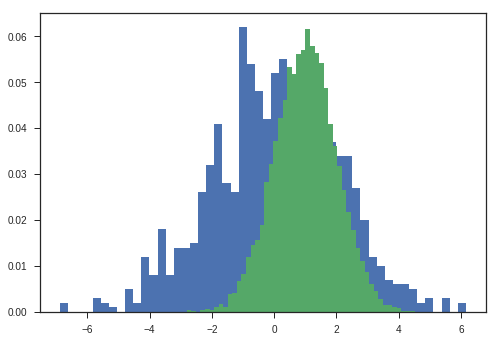

In [4]:
weights_tr = np.ones_like(data_tr)/len(data_tr)
weights_te = np.ones_like(data_te)/len(data_te)
plt.hist(data_tr, bins=50, weights=weights_tr)
plt.hist(data_te, bins=50, weights=weights_te)
plt.show()

In [5]:
class UlsifLooCV(object):
    def __init__(self, sigmas, lambdas):
        self._sigmas = sigmas
        self._lambdas = lambdas
    
    def fit(self, X_tr, X_te):
        n_tr = len(data_tr)
        n_te = len(data_te)
        b = min(100, n_te)
        n = min(n_tr, n_te)
        means = sklearn.cluster.KMeans(b).fit(X_tr).cluster_centers_
        
        def norm(mean, sigma):
            cov = np.eye(len(mean)) * sigma
            return lambda x: scipy.stats.multivariate_normal.pdf(x, mean=mean, cov=cov)
        
        score = np.inf
        for sigma in self._sigmas:
            bases = [norm(mean, sigma) for mean in means]
            H = np.mean([[b1(X_tr) * b2(X_tr) for b1 in bases] for b2 in bases], axis=2)
            h = np.mean([b(X_te) for b in bases], axis=1)
            Phi_tr = np.array([b(X_tr[:n]) for b in bases])
            Phi_te = np.array([b(X_te[:n]) for b in bases])
            
            for lamb in self._lambdas:
                B = H + lamb * (n_tr - 1) / n_tr * np.eye(b)
                B_inv_phi_tr = np.linalg.solve(B, Phi_tr)
                denom = n_tr - np.sum(Phi_tr * B_inv_phi_tr, axis=0)
                B0 = np.repeat(np.linalg.solve(B, h), n).reshape(b, n)
                B0 += B_inv_phi_tr * (h.dot(B_inv_phi_tr) / denom).reshape(1, -1)
                B1 = np.linalg.solve(B, Phi_te)
                B1 += B_inv_phi_tr * (np.sum(Phi_te * B_inv_phi_tr, axis=0) / denom).reshape(1, -1)
                B2 = (n_tr - 1) / n_tr / (n_te - 1) * (n_te * B0 - B1)
                B2[B2 < 0] = 0
                w_tr = np.sum(Phi_tr * B2, axis=0)
                score_new = w_tr.dot(w_tr) / n / 2 - np.sum(Phi_te * B2) / n
                if score > score_new:
                    score = score_new
                    self.sigma_opt = sigma
                    self.lambda_opt = lamb
                    print('sigma: %f, lambda: %f, score: %f' % (sigma, lamb, score))
        
        return self

In [6]:
sigmas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1, 1.25, 1.5, 2, 2.5, 3, 5, 10]
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75]
cv = UlsifLooCV(sigmas=sigmas, lambdas=lambdas)
cv.fit(data_tr.reshape(-1, 1), data_te.reshape(-1, 1))

sigma: 0.010000, lambda: 0.000001, score: 1241.801064
sigma: 0.010000, lambda: 0.000010, score: 308.730390
sigma: 0.010000, lambda: 0.000100, score: 22.673460
sigma: 0.010000, lambda: 0.001000, score: 0.284254
sigma: 0.010000, lambda: 0.010000, score: -0.766136
sigma: 0.010000, lambda: 0.050000, score: -0.813370
sigma: 0.010000, lambda: 0.100000, score: -0.818133
sigma: 0.010000, lambda: 0.200000, score: -0.819160
sigma: 0.050000, lambda: 0.010000, score: -0.831689
sigma: 0.050000, lambda: 0.050000, score: -0.835127
sigma: 0.100000, lambda: 0.050000, score: -0.835177
sigma: 0.200000, lambda: 0.010000, score: -0.836083
sigma: 0.200000, lambda: 0.050000, score: -0.838704
sigma: 0.300000, lambda: 0.010000, score: -0.838974
sigma: 0.300000, lambda: 0.050000, score: -0.840913
sigma: 0.500000, lambda: 0.010000, score: -0.842010
sigma: 0.500000, lambda: 0.050000, score: -0.843035
sigma: 0.750000, lambda: 0.010000, score: -0.843170


In [7]:
cv.sigma_opt, cv.lambda_opt

(0.75, 0.01)

In [8]:
n_b = 100
sigma = cv.sigma_opt
lamb = cv.lambda_opt
means = sklearn.cluster.KMeans(n_b).fit(data_tr.reshape(-1, 1)).cluster_centers_[:, 0]

def norm(mean): return lambda x: scipy.stats.norm.pdf(x, loc=mean, scale=sigma)
bases = [norm(mean) for mean in means]

In [9]:
H = np.mean([[b1(data_tr) * b2(data_tr) for b1 in bases] for b2 in bases], axis=2)
h = np.mean([b(data_te) for b in bases], axis=1)

In [10]:
alpha = np.linalg.solve(H + lamb * np.eye(n_b), h)
alpha[alpha < 0] = 0

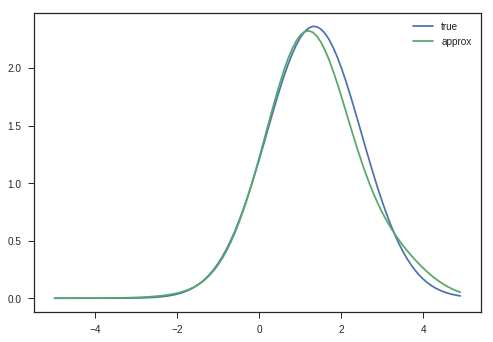

In [11]:
def true_ratio(x):
    return scipy.stats.norm(1, 1).pdf(x) / scipy.stats.norm(0, 2).pdf(x)

def approximated_ratio(x):
    return np.sum([alpha[i] * bases[i](x) for i in range(n_b)])

plt.plot(np.arange(-5, 5, 0.1), [true_ratio(x) for x in np.arange(-5, 5, 0.1)], label='true')
plt.plot(np.arange(-5, 5, 0.1), [approximated_ratio(x) for x in np.arange(-5, 5, 0.1)], label='approx')
plt.legend()